In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch.amp import autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random
import tempfile
import pickle
import joblib

from transform import classify_features

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from datetime import datetime, timedelta


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps')
torch.set_float32_matmul_precision('high')


import torch._dynamo
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = True

import ray
from ray import tune, train
from ray.tune import CLIReporter, ExperimentAnalysis, Callback, Tuner
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.air import session
from ray.train import Checkpoint, get_checkpoint, RunConfig, report
from ray.tune.stopper import TrialPlateauStopper


In [63]:
ray.shutdown()  # Shutdown any existing Ray instances
ray.init(ignore_reinit_error=True)

Usage stats collection is enabled. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2024-11-06 01:28:25,747	INFO worker.py:1807 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.20
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [64]:
def set_seed(seed=None):
    if seed is None:
        seed = 1
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'


In [65]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets):
        # Calculate MSE and then take the square root to get RMSE
        return torch.sqrt(self.mse(predictions, targets)+1e-6)

In [66]:
input_file = r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\luz_transformed_data.csv'
data = pd.read_csv(input_file)
data = data.fillna(0)

In [67]:
X = data.copy().values
y = data[['GWAP','LWAP']].values

In [68]:
colpath = r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\LUZ_Daily_Complete.csv' #get columns 
col = pd.read_csv(colpath).fillna(0)
minmaxcols, boxcoxcols, yeojohnsoncols = classify_features(col)
boxcoxcolsy =boxcoxcols[:2]

In [69]:
print(boxcoxcolsy)

['GWAP', 'LWAP']


In [70]:
train_size = int(0.6 * len(X))  # 60% for training
val_size = int(0.20 * len(X))   # 20% for validation
test_size = len(X) - train_size - val_size  

train_data = X[:train_size]
train_labels = y[:train_size]

val_data = X[train_size:train_size + val_size]
val_labels = y[train_size:train_size + val_size]

test_data = X[train_size + val_size:]
test_labels = y[train_size + val_size:]
seq_len=7
batch_size=64

In [71]:
class TimeSeriesDataset(Dataset):
    
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.X) - self.seq_len 
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len])

In [72]:
class LSTMCustomCell(nn.Module):
    def __init__(self, input_size, hidden_size, activation_fn):
        super(LSTMCustomCell, self).__init__()
        self.hidden_size = hidden_size
        self.activation_fn = activation_fn
        
        # Combine all gate matrices into one large matrix for efficiency
        self.W_ih = nn.Linear(input_size, 4 * hidden_size, bias=False)
        self.W_hh = nn.Linear(hidden_size, 4 * hidden_size, bias=False)
        self.bias = nn.Parameter(torch.zeros(4 * hidden_size))
        
    def forward(self, x, hidden):
        h, c = hidden
        
        # Optimized matrix multiplication and bias addition
        gates = self.W_ih(x) + self.W_hh(h) + self.bias
        
        # Split into 4 gate vectors
        i_gate, f_gate, o_gate, g_gate = torch.chunk(gates, 4, dim=1)
        
        # Sigmoid activations for gates
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        o_gate = torch.sigmoid(o_gate)
        
        # Apply the custom activation function for the cell gate
        g_gate = self.activation_fn(g_gate)
        
        # Compute the new cell state
        c_next = f_gate * c + i_gate * g_gate
        
        # Compute the new hidden state using the custom activation function
        h_next = o_gate * self.activation_fn(c_next)
        
        return h_next, c_next

In [73]:
class LSTMCustom(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, num_layers=1, activation_fn=torch.tanh, batch_first=False):
        super(LSTMCustom, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.activation_fn = activation_fn
        self.batch_first = batch_first
        self.dropout = dropout
        # Create a list of LSTM cells
        self.cells = nn.ModuleList([LSTMCustomCell(input_size if i == 0 else hidden_size, hidden_size, activation_fn) for i in range(num_layers)])
        self.dropout_layer = nn.Dropout(dropout) if dropout > 0.0 else None
    def forward(self, x, hidden=None):
        # Determine the correct input shape
        if self.batch_first:
            batch_size, seq_len, _ = x.size()
            x = x.transpose(0, 1)  # Convert to (seq_len, batch_size, input_size) for processing
        else:
            seq_len, batch_size, _ = x.size()
        
        if hidden is None:
            # Initialize hidden and cell states with zeros
            h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
            c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        else:
            h, c = hidden
        
        outputs = []
        
        # Iterate over each time step
        for t in range(seq_len):
            x_t = x[t, :, :]  # Input at time step t
            for i, cell in enumerate(self.cells):

                h[i], c[i] = cell(x_t, (h[i], c[i]))
                x_t = h[i]  # Pass hidden state to the next layer
                if self.dropout_layer and i < self.num_layers - 1:
                    x_t = self.dropout_layer(x_t)
            outputs.append(h[-1].unsqueeze(0))  # Collect output from the last layer
        
        # Stack the outputs across time steps
        outputs = torch.cat(outputs, dim=0)
        
        # Convert output back to (batch_size, seq_len, hidden_size) if batch_first is True
        if self.batch_first:
            outputs = outputs.transpose(0, 1)
        
        # Return outputs and the last hidden and cell states
        return outputs, (torch.stack(h), torch.stack(c))



In [74]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers,dropout,activation_fn):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        #self.lstm = LSTMCustom(input_size, hidden_size, dropout, num_layers, activation_fn, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

        # Additional fully connected layers with batch normalization
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)

        # Final output layer
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
        # Store activation function for layers
        self.activation_fn = activation_fn

    def forward(self, x):
        # Forward propagate LSTM
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Get last time step's output

        # Pass through fully connected layers with activation and batch normalization
        out = self.fc1(out)
        out = self.batch_norm1(out)
        out = self.activation_fn(out)  # Apply chosen activation function
        
        out = self.fc2(out)
        out = self.batch_norm2(out)
        out = self.activation_fn(out)  # Apply chosen activation function

        # Final output layer with sigmoid
        out = self.fc_out(out)
        out = self.sigmoid(out)

        return out

In [75]:
#model = torch.compile(model)

In [76]:
input_size = train_data.shape[1]  # Number of features
hidden_size = 128
output_size = train_labels.shape[1]  # Number of output features
num_layers = 2
activation_fn = torch.relu
dropout=0.1
#model = LSTMModel(input_size, hidden_size,output_size, num_layers,dropout,activation_fn).to(device)
epoch=100
# Define loss function and optimizer
train_criterion = nn.MSELoss()  # Use MSE loss for regression tasks
test_criterion = nn.L1Loss()
#test_criterion = RMSELoss()
#optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [77]:
scaler = torch.amp.GradScaler()

def trainm(model, dataloader, device, optimizer, criterion):
    
    model.train()
    total_loss = 0.0  # Initialize total loss to 0
    total_samples = 0  # Initialize total sample count to 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)    

        loss = criterion(outputs, targets)

        loss.backward()
    
        optimizer.step()

        # Accumulate the total loss and sample count
        total_loss += loss.item() * inputs.size(0)  # Total loss for the batch
        total_samples += inputs.size(0)  # Number of samples in the current batch

    # Return the average loss over all samples
    return total_loss / total_samples if total_samples > 0 else 0.0  # Avoid division by zero

        
       

In [78]:
@torch.no_grad()
def evaluate(model, dataloader, device, criterion):
    
    model.eval()
    total_loss = 0.0  # Initialize total loss
    total_samples = 0  # Initialize total sample count to 0

    for i, (inputs, target) in enumerate(dataloader):
        inputs, target = inputs.to(device), target.to(device)

        # Forward pass
        outputs = model(inputs)

        predictions = outputs.to(device)

        loss = criterion(predictions, target)

        # Accumulate the loss and sample count
        total_loss += loss.item() * inputs.size(0)  # Total loss for the batch
        total_samples += inputs.size(0)  # Number of samples in the current batch

    # Return the average loss over all samples
    return total_loss / total_samples if total_samples > 0 else 0.0  # Avoid division by zero


In [79]:
def load_data():
    train_dataset = TimeSeriesDataset(train_data, train_labels, seq_len)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)

    val_dataset = TimeSeriesDataset(val_data, val_labels, seq_len)    
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False) 
    
    return train_dataloader, val_dataloader

In [80]:
def train_lstm(config,epoch):
    
    def set_seed(seed):
    
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.benchmark = False
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

    set_seed(config["seed"])
    
    activation_fn_mapping = {
        "tanh": torch.tanh,
        "relu": torch.relu,
        "elu": torch.nn.functional.elu
    }
    activation_fn = activation_fn_mapping[config["activation_fn"]]
    model = LSTMModel(input_size, config["hidden_size"], output_size, config["num_layers"],config["dropout"],activation_fn=activation_fn).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',  config["factor"],config["patience"])
    train_dataloader, val_dataloader = load_data()
    for e in range(epoch):  # Replace with your actual number of epochs
        trainm(model, train_dataloader, device, optimizer, train_criterion)
        val_loss = evaluate(model, val_dataloader, device, test_criterion)
        scheduler.step(val_loss)
        # Report the results using tune.report
        

            # Report the results using train.report
        train.report(
            {
                "loss": val_loss,
                  # Report the validation loss # Assuming you calculate accuracy
            }  # Pass the checkpoint object
        )


In [81]:
minmax_fit_loaded = joblib.load(r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load(r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\box-cox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load(r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\yeo-johnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load(r'D:\School\ADMU\4Y\SEM 1\MATH 199.11\Final\DAILY\Luzon\box-cox_pipeliney.pkl')

In [82]:
reordered_data = data[minmaxcols + boxcoxcols + yeojohnsoncols]

# Initialize an empty DataFrame for untransformed data
untransformed_data = pd.DataFrame(columns=minmaxcols + boxcoxcols + yeojohnsoncols)

# Inverse MinMax scaling
if minmaxcols:
    untransformed_data[minmaxcols] = minmax_fit_loaded.inverse_transform(reordered_data[minmaxcols])

# Inverse Box-Cox transformation
if boxcoxcols:
    # Ensure the input is a DataFrame with the correct feature names
    untransformed_data[boxcoxcols] = boxcox_fit_loaded.inverse_transform(reordered_data[boxcoxcols].values)

# Inverse Yeo-Johnson transformation
if yeojohnsoncols:
    # Ensure the input is a DataFrame with the correct feature names
    untransformed_data[yeojohnsoncols] = yeojohnson_fit_loaded.inverse_transform(reordered_data[yeojohnsoncols].values)

X_u = untransformed_data.copy().values

y_u = untransformed_data[['GWAP','LWAP']].values

d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [83]:
u_train_data = X_u[:train_size]
u_train_labels = y_u[:train_size]

u_val_data = X_u[train_size:train_size + val_size]
u_val_labels = y_u[train_size:train_size + val_size]

u_test_data = X_u[train_size + val_size:]
u_test_labels = y_u[train_size + val_size:]

In [84]:
def load_test():
    test_dataset = TimeSeriesDataset(test_data, u_test_labels, seq_len)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
    return test_dataloader

In [85]:
@torch.no_grad()
def test_best_model(optimized_model):
    
    # Load test data
    test_loader = load_test()
    
    # Call evaluate function and get test loss
    optimized_model.eval()
    total_loss = 0.0
    total_samples = 0
    all_predictions = []
    all_targets = []

    # Evaluation loop
    with torch.no_grad():
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)

            # Forward pass
            outputs = optimized_model(inputs)
            predictions = outputs.to(device)

            # Accumulate predictions and targets
            all_predictions.append(predictions)
            all_targets.append(target)

    # Concatenate all predictions and targets for inverse transformation
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Apply inverse transformations to predictions and targets
    all_predictions_inverse = boxcoxy_fit_loaded.inverse_transform(all_predictions.cpu().numpy())
    all_targets = all_targets.cpu().numpy()  # Ensure targets are in NumPy format

    # Calculate untransformed loss
    if all_predictions_inverse.shape == all_targets.shape:
        untransformed_loss = test_criterion(
            torch.tensor(all_predictions_inverse, dtype=torch.float32).to(device),
            torch.tensor(all_targets, dtype=torch.float32).to(device)
        )
        total_loss += untransformed_loss.item() * all_predictions.size(0)
        total_samples += all_predictions.size(0)

    # Calculate and return the average loss
    average_loss = total_loss / total_samples if total_samples > 0 else 0.0
    return average_loss, all_predictions_inverse


In [96]:
def plot_predictions(all_predictions_inverse):
    # Load actual values for GWAP and LWAP
    actual_gwap = np.array(col['GWAP'])  # Convert to NumPy array
    actual_lwap = np.array(col['LWAP'])  # Convert to NumPy array

    # Calculate the full date range for the entire dataset
    full_date_range = pd.date_range(start="2022-01-01", end="2023-12-31", freq="D").to_numpy()

    # Determine the number of test data points and create test date range
    test_data_points = all_predictions_inverse.shape[0]
    test_start_date = datetime(2023, 12, 31) - timedelta(days=test_data_points - 1)
    test_date_range = pd.date_range(start=test_start_date, periods=test_data_points, freq="D").to_numpy()


    # Extract predictions as NumPy arrays
    gwap_predictions = all_predictions_inverse[:, 0]
    lwap_predictions = all_predictions_inverse[:, 1]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(full_date_range, actual_gwap, label='GWAP Actual (Full Data)', color='blue')
    plt.plot(full_date_range, actual_lwap, label='LWAP Actual (Full Data)', color='green')
    plt.plot(test_date_range, gwap_predictions, label='GWAP Prediction', color='orange')
    plt.plot(test_date_range, lwap_predictions, label='LWAP Prediction', color='red')

    # Customize plot
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('GWAP and LWAP Predictions vs Actual Values')
    plt.legend()
    plt.show()

In [ ]:
def main(epoch):
    set_seed(1)
    search_space = {
        "hidden_size": tune.choice([ 32, 64, 128, 256, 512]),
        "lr": tune.loguniform(1e-5, 1e-2),
        "weight_decay": tune.loguniform(1e-4, 1e-1),
        "dropout": tune.uniform(0, 0.5),
        "activation_fn": tune.choice(["tanh","relu","elu"]),
        "seed": 1,
        "num_layers": tune.choice([2, 3,4]),
        "patience": tune.choice([5, 10, 15]),
        "factor": tune.uniform(0.1, 0.5)
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=50,
        reduction_factor=2
    )
    plateau_stopper = TrialPlateauStopper(metric="val_loss",mode="min")

    reporter = CLIReporter(
        metric_columns=["loss", "training_iteration"]
    )

    def trial_dirname_creator(trial):
        return f"trial_{trial.trial_id}"

    trainable_with_params = tune.with_parameters(train_lstm, epoch=epoch)


    trainable_with_resources = tune.with_resources(trainable_with_params, resources={"cpu": 2, "gpu": 0.1})

    # Step 1: Hyperparameter tuning
    tuner = Tuner(
        trainable_with_resources,  # Removed seed here
        param_space=search_space,
        tune_config=tune.TuneConfig(
            search_alg=OptunaSearch(metric="loss", mode="min"),
            num_samples=1000,
            scheduler=scheduler,
            trial_dirname_creator=trial_dirname_creator
        ),
        run_config=RunConfig(
            progress_reporter=reporter,
            verbose=1,
            stop=plateau_stopper
        )
    )
    
    # Run the tuner and collect the results
    results = tuner.fit()
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(best_result.metrics["loss"]))

    activation_fn_mapping = {
        "tanh": torch.tanh,
        "relu": torch.relu,
        "elu": torch.nn.functional.elu
    }
    
    optimized_activation_fn = activation_fn_mapping.get(best_result.config["activation_fn"])
    
    # Step 2: Training and testing with different seeds
    total_loss = 0.0
    num_seeds = 10  # Total seeds to test
    train_dataloader,val_dataloader=load_data()
    all_pred_inverses = []
    all_train_losses = []
    all_val_losses = []
    for seed in range(1, num_seeds + 1):
        set_seed(seed)
        optimized_model = LSTMModel(
            input_size=input_size,
            hidden_size=best_result.config["hidden_size"],
            output_size=output_size,
            num_layers=best_result.config["num_layers"],
            dropout=best_result.config["dropout"],
            activation_fn=optimized_activation_fn
        ).to(device)

        optimizer_op = optim.AdamW(
            optimized_model.parameters(),
            lr=best_result.config["lr"],
            weight_decay=best_result.config["weight_decay"]
        )
        scheduler_op = ReduceLROnPlateau(optimizer_op, 'min', factor=best_result.config["factor"], patience=best_result.config["patience"])

        train_losses = []
        val_losses = []

    # Train the model with the best configuration and the current seed
        for e in range(epoch):
            train_loss = trainm(optimized_model, train_dataloader, device, optimizer_op, train_criterion)
            val_loss = evaluate(optimized_model, val_dataloader, device, test_criterion)
            scheduler_op.step(val_loss)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

    # Test the model using the trained optimized_model
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        loss, pred_inverse = test_best_model(optimized_model)  # Modify this function to return loss
        total_loss += loss
        all_pred_inverses.append(np.array(pred_inverse))


    # Calculate average loss across all seeds
    average_loss = total_loss / num_seeds
    print("Average test loss over {} runs: {:.4f}".format(num_seeds, average_loss))
    stacked_predictions = np.stack(all_pred_inverses)
    avg_pred_inverse = np.mean(stacked_predictions, axis=0)  # Average across seeds

# Plot the averaged predictions
    plot_predictions(avg_pred_inverse)
    for i in range(num_seeds):
        plt.figure(figsize=(10, 5))
        plt.plot(all_train_losses[i], label=f'Training Loss Seed {i+1}')
        plt.plot(all_val_losses[i], label=f'Validation Loss Seed {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Training and Validation Losses per Epoch for Seed {i+1}')
        plt.show()
    


2024-11-06 01:40:43,391	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2024-11-06 01:40:43,399] A new study created in memory with name: optuna


== Status ==
Current time: 2024-11-06 01:40:43 (running for 00:00:00.13)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 100.000: None | Iter 50.000: None
Logical resource usage: 2.0/20 CPUs, 0.1/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOJ~1/AppData/Local/Temp/ray/session_2024-11-06_01-28-23_669804_22884/artifacts/2024-11-06_01-40-43/train_lstm_2024-11-06_01-40-43/driver_artifacts
Number of trials: 1/2 (1 PENDING)


== Status ==
Current time: 2024-11-06 01:40:48 (running for 00:00:05.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 100.000: None | Iter 50.000: None
Logical resource usage: 4.0/20 CPUs, 0.2/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOJ~1/AppData/Local/Temp/ray/session_2024-11-06_01-28-23_669804_22884/artifacts/2024-11-06_01-40-43/train_lstm_2024-11-06_01-40-43/driver_artifacts
Number of trials: 2/2 (1 PENDING, 1 RUNNING)




2024-11-06 01:40:51,541	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Paulo John Mercado/ray_results/train_lstm_2024-11-06_01-40-43' in 0.0173s.
2024-11-06 01:40:51,545	INFO tune.py:1041 -- Total run time: 8.15 seconds (8.12 seconds for the tuning loop).


== Status ==
Current time: 2024-11-06 01:40:51 (running for 00:00:08.14)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 100.000: None | Iter 50.000: None
Logical resource usage: 2.0/20 CPUs, 0.1/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/PAULOJ~1/AppData/Local/Temp/ray/session_2024-11-06_01-28-23_669804_22884/artifacts/2024-11-06_01-40-43/train_lstm_2024-11-06_01-40-43/driver_artifacts
Number of trials: 2/2 (2 TERMINATED)


Best trial config: {'hidden_size': 256, 'lr': 0.0015879738397943485, 'weight_decay': 0.015007497644734948, 'dropout': 0.34495899244204487, 'activation_fn': 'elu', 'seed': 1, 'num_layers': 4, 'patience': 15, 'factor': 0.1719485858699376}
Best trial final validation loss: 0.16112067411057382


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have val

Average test loss over 10 runs: 4089.9547


d:\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


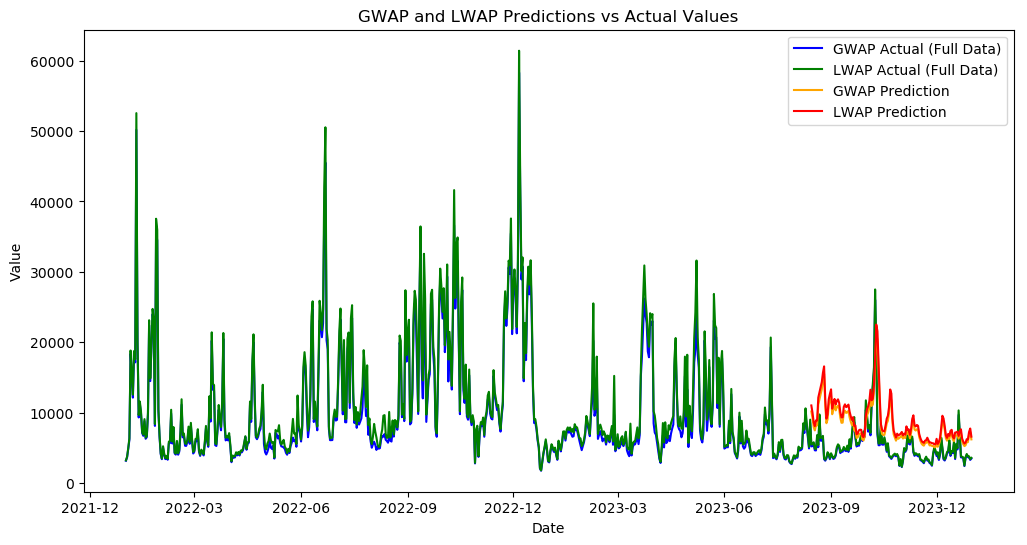

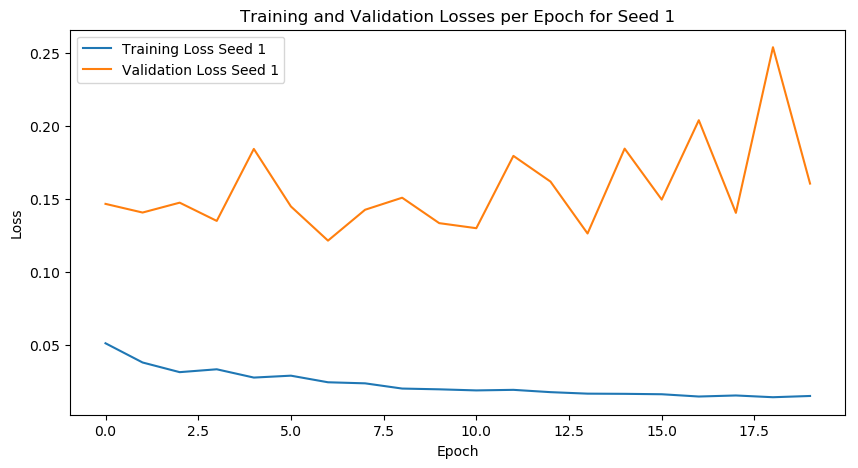

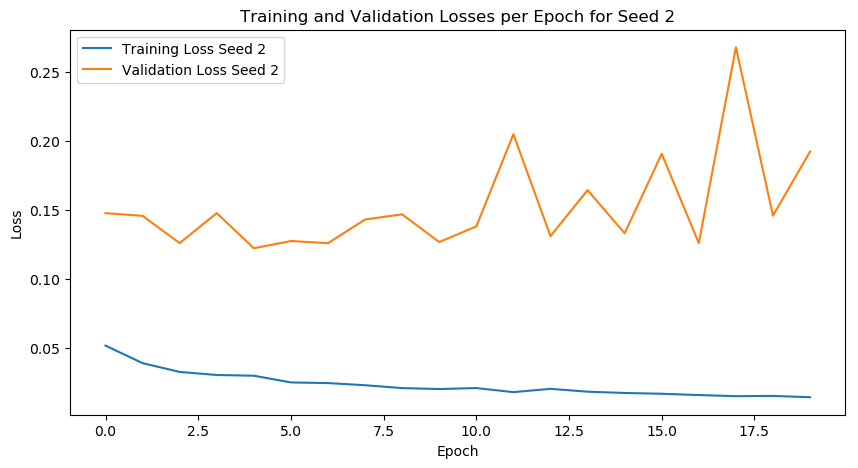

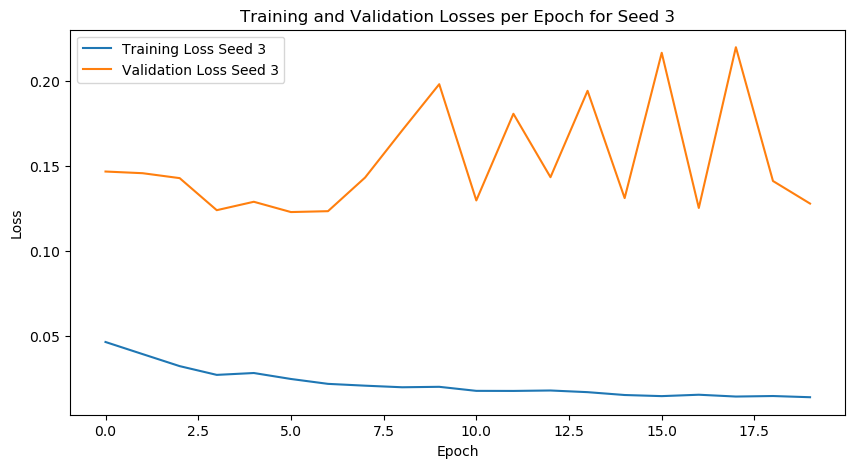

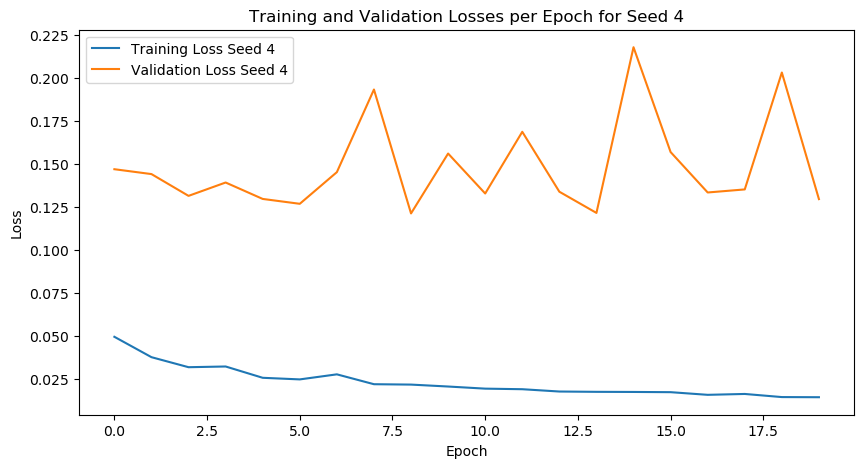

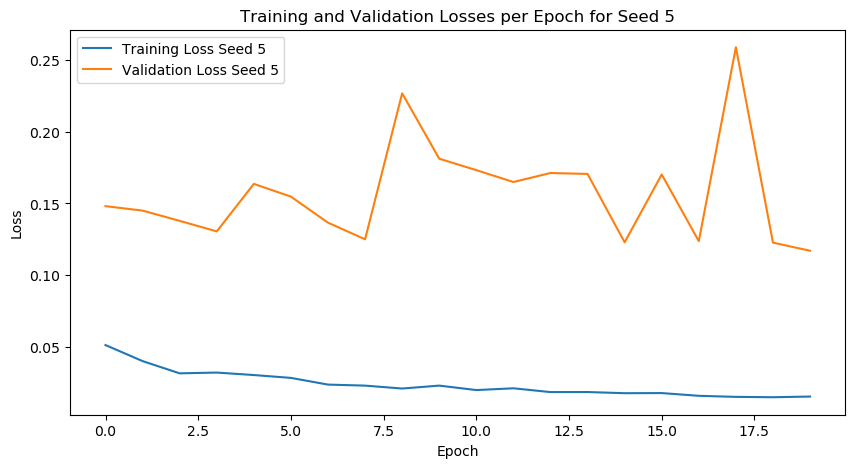

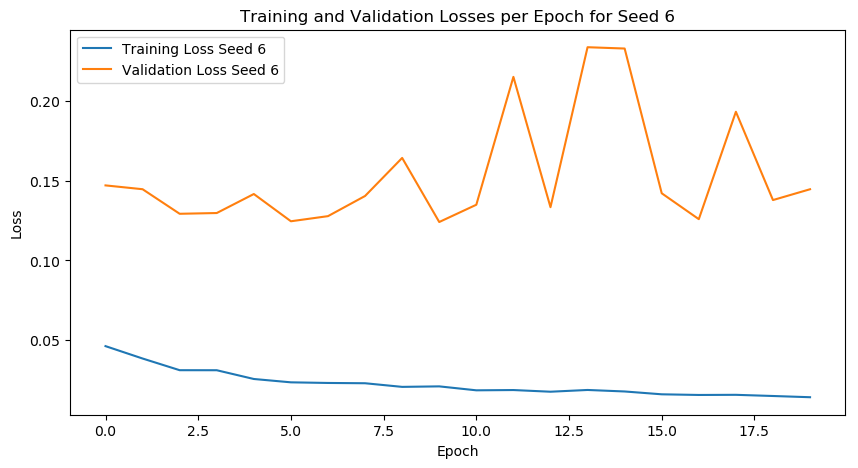

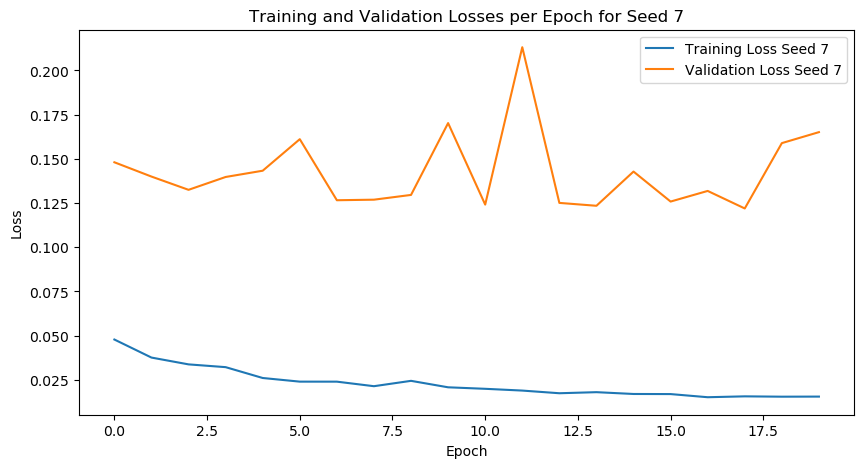

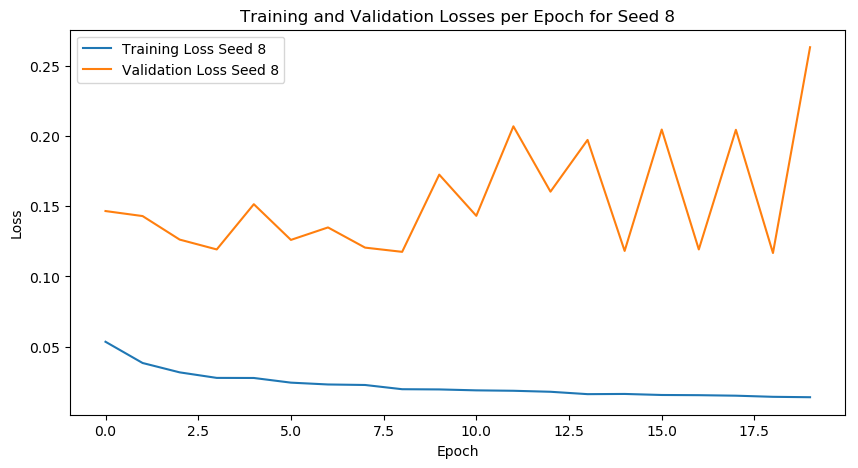

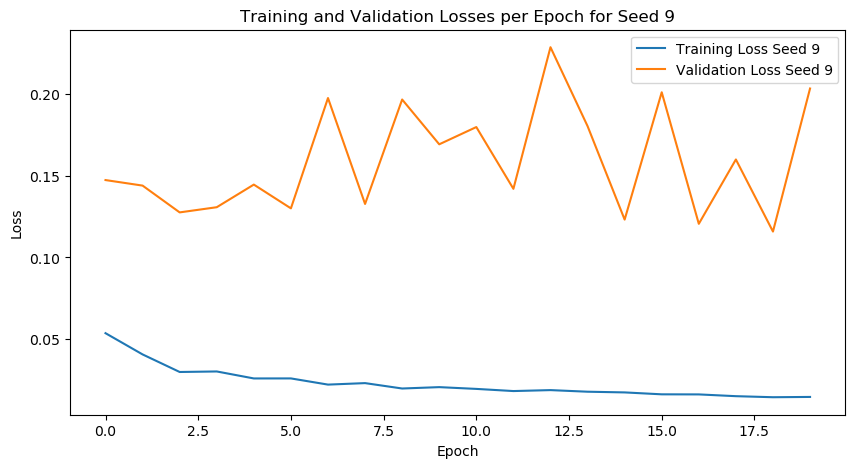

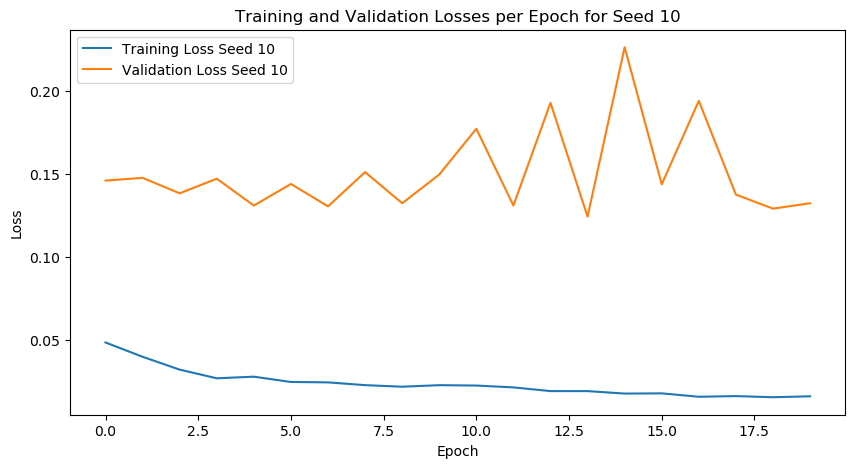

In [ ]:
main(100)